<a href="https://colab.research.google.com/github/UkeshThapa/Snowmelt-Driven-Streamflow-Prediction/blob/main/snowmelt_prediction_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U keras-tuner
!pip install keras==2.12.0
!pip install hydroeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.12.0 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hydroeval as he
# normalize the data
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# model library

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD,RMSprop,Adam,Adadelta,Adagrad,Adamax,Nadam

# hyperparameter tuner
import keras_tuner as kt
import time
# model checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError,MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError


# loss

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [24]:

# Load your dataset

def load_dataset(path):
    return pd.read_csv(path)


file_path = "/content/drive/MyDrive/Colab_Notebooks/Dataset/bigdata.csv"
df_snow_melting = load_dataset(file_path)

df_snow_melting


,Date,Q,SCA,T,P,Day,Relative Humidity,Wind speed,Wind direction,Snow depth
0,1/1/2001,2.69,345.815123,-4.169740,0.000000,1,60.49,3.18,220.08,0.000170
1,1/2/2001,2.53,343.608727,-4.142604,0.000000,2,53.93,1.86,210.97,0.000133
2,1/3/2001,2.53,341.437417,-5.148725,0.000000,3,42.20,1.49,239.45,0.000128
3,1/4/2001,2.43,339.336277,-6.523695,0.031144,4,40.48,1.91,249.20,0.000122
4,1/5/2001,2.53,337.340394,-6.860106,0.000000,5,27.34,2.14,334.61,0.000116
...,...,...,...,...,...,...,...,...,...,...
4012,12/26/2012,2.91,228.615063,-5.651230,0.000000,361,46.49,1.43,257.42,0.000466
4013,12/27/2012,2.91,219.264614,-5.501225,0.000000,362,43.99,2.98,246.87,0.000437
4014,12/28/2012,3.03,210.043412,-5.526874,0.000000,363,27.19,2.54,263.59,0.000410
4015,12/29/2012,2.97,201.080703,-5.107484,0.000000,364,33.50,3.10,256.97,0.000379


In [25]:
features = ['Date',"Q","SCA","T","P"]
# features = ["Q"]
df_snow_melting = df_snow_melting[features]

In [26]:
import datetime

def str_to_datetime(s):
    split = s.split('/')
    month,day,year = int(split[0]),int(split[1]),int(split[2])

    return datetime.datetime(year=year,month=month,day=day)


In [27]:
df_snow_melting['Date'] = df_snow_melting['Date'].apply(str_to_datetime)

df_snow_melting

<ipython-input-27-164b30e8e586>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_snow_melting['Date'] = df_snow_melting['Date'].apply(str_to_datetime)


,Date,Q,SCA,T,P
0,2001-01-01,2.69,345.815123,-4.169740,0.000000
1,2001-01-02,2.53,343.608727,-4.142604,0.000000
2,2001-01-03,2.53,341.437417,-5.148725,0.000000
3,2001-01-04,2.43,339.336277,-6.523695,0.031144
4,2001-01-05,2.53,337.340394,-6.860106,0.000000
...,...,...,...,...,...
4012,2012-12-26,2.91,228.615063,-5.651230,0.000000
4013,2012-12-27,2.91,219.264614,-5.501225,0.000000
4014,2012-12-28,3.03,210.043412,-5.526874,0.000000
4015,2012-12-29,2.97,201.080703,-5.107484,0.000000


In [28]:
import pandas as pd
import numpy as np

# data scaled

df_input = df_snow_melting[['Q','SCA', 'T','P']]


def min_max_scaling(data):
    # Subtract the minimum value and divide by the range
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = (data - min_val) / (max_val - min_val)

    return scaled_data, min_val, max_val

# Assuming df_snow_melting is your DataFrame
columns_to_scale = ['Q', 'SCA', 'T','P']
scaled_df = df_input.copy()

# Apply min-max scaling to specified columns
for column in columns_to_scale:
    scaled_df[column], _, _ = min_max_scaling(df_input[column])

# Print the scaled DataFrame
print(scaled_df)


             Q       SCA         T         P
0     0.087577  0.851791  0.302737  0.000000
1     0.080424  0.844592  0.304062  0.000000
2     0.080424  0.837508  0.254949  0.000000
3     0.075953  0.830653  0.187831  0.000215
4     0.080424  0.824141  0.171409  0.000000
...        ...       ...       ...       ...
4012  0.097412  0.469406  0.230419  0.000000
4013  0.097412  0.438898  0.237742  0.000000
4014  0.102776  0.408812  0.236490  0.000000
4015  0.100094  0.379570  0.256962  0.000000
4016  0.097412  0.351593  0.261586  0.000000

[4017 rows x 4 columns]


In [29]:
def df_to_X_y(df, window_size = 5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

WINDOW_SIZE = 2

X, y = df_to_X_y(scaled_df,WINDOW_SIZE)

X.shape, y.shape

((4015, 2, 4), (4015,))

In [30]:
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid

from tensorflow import keras
from tensorflow.keras import layers


In [31]:

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

from tensorflow.keras.callbacks import EarlyStopping

def build_model(hp):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for i in range(hp.Int('num_transformer_blocks', min_value=2, max_value=8, step=2)):
        x = transformer_encoder(x,
                               hp.Int('head_size', min_value=8, max_value=256, step=32),
                               hp.Int('num_heads', min_value=2, max_value=16),
                               hp.Int('ff_dim', min_value=4, max_value=64),
                               hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.6))

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    for i in range(hp.Int('num_mlp_layers', min_value=1, max_value=3)):
        x = layers.Dense(hp.Int(f'mlp_units_{i}', min_value=32, max_value=256, step=32))(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(hp.Float(f'mlp_dropout_{i}', min_value=0.1, max_value=0.6))(x)

    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)

    # Choose optimizer and learning rate
    optimizer = hp.Choice('optimizer', values=['adam', 'adamax'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2)

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        opt = Adamax(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)

    model.compile(optimizer=opt, loss=MeanSquaredError(), metrics=['mae', RootMeanSquaredError()])

    return model


In [32]:
input_shape = X.shape[1:]
input_shape

(2, 4)

In [39]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import keras_tuner as kt

# Define your input shape
input_shape = X.shape[1:]


# Assume you have your data X and y
best_model_hyperparameters = None
best_model_mae = float('inf')

worst_model_hyperparameters = None
worst_model_mae = float('-inf')

# Initialize K-Fold cross-validation for the outer loop
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)


# Perform Nested Cross-Validation
nested_scores = []

for fold_outer_idx, (train_ix, test_ix) in enumerate(outer_cv.split(X)):
    X_train_outer, X_test_outer = X[train_ix], X[test_ix]
    y_train_outer, y_test_outer = y[train_ix], y[test_ix]

    # Inner loop for hyperparameter tuning
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

    for fold_idx, (train_ix_inner, val_ix) in enumerate(inner_cv.split(X_train_outer)):
        X_train_inner, X_val = X_train_outer[train_ix_inner], X_train_outer[val_ix]
        y_train_inner, y_val = y_train_outer[train_ix_inner], y_train_outer[val_ix]

        tuner = kt.RandomSearch(
            build_model,
            objective='val_loss',
            max_trials=15,
            directory=f'/content/drive/MyDrive/research/keras_tuner_random_dir_fold_tf_{fold_outer_idx}_{fold_idx}',
            project_name=f'/content/drive/MyDrive/research/hyperparameter_random_tuning_fold_tf_{fold_outer_idx}_{fold_idx}'

        )

        # Search for the best hyperparameters
        tuner.search(X_train_inner, y_train_inner, validation_data=(X_val, y_val), epochs=30)

        # tuner.search(X_train_inner, y_train_inner, validation_data=(X_val, y_val), epochs=30)  # Adjust epochs as needed

        best_hps = tuner.oracle.get_best_trials(1)[0].hyperparameters
        print(f"Best hyperparameters for fold {fold_idx}: {best_hps}")

        model = build_model(best_hps)
        es = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

        model.fit(
            X_train_inner,
            y_train_inner,
            validation_data=(X_val, y_val),
            epochs=100,
            batch_size=32,
            callbacks=[es],
        )

        y_pred = model.predict(X_val)
        mae = mean_squared_error(y_val, y_pred)

         # Update best model
        if mae < best_model_mae:
            best_model_mae = mae
            best_model_hyperparameters = best_hps
            best_model = model

        # Update worst model
        if mae > worst_model_mae:
            worst_model_mae = mae
            worst_model_hyperparameters = best_hps
            worst_model = model

    # Now that we have the best and worst models, evaluate them on the test set
    start_time = time.time()
    y_pred_best = best_model.predict(X_test_outer)
    y_pred_worst = worst_model.predict(X_test_outer)
    end_time = time.time()

    mse_best = mean_squared_error(y_test_outer, y_pred_best)
    mae_best = mean_absolute_error(y_test_outer, y_pred_best)
    rmse_best = np.sqrt(mse_best)

    nse_best = he.evaluator(he.nse, y_pred_best, y_test_outer)
    kge_best, r, alpha, beta = he.evaluator(he.kge, y_pred_best, y_test_outer)
    print("Best Model:")
    print("KGE : ", kge_best)

    r2_best = r2_score(y_test_outer, y_pred_best)
    time_duration = end_time - start_time

    mse_worst = mean_squared_error(y_test_outer, y_pred_worst)
    mae_worst = mean_absolute_error(y_test_outer, y_pred_worst)
    rmse_worst = np.sqrt(mse_worst)

    nse_worst = he.evaluator(he.nse, y_pred_worst, y_test_outer)
    kge_worst, r, alpha, beta = he.evaluator(he.kge, y_pred_worst, y_test_outer)
    print("Worst Model:")
    print("KGE : ", kge_worst)

    r2_worst = r2_score(y_test_outer, y_pred_worst)
    time_duration = end_time - start_time

    nested_scores.append({
        "Best Model": {
            "MSE": mse_best,
            "R^2": r2_best,
            "RMSE": rmse_best,
            "MAE": mae_best,
            "testing time": time_duration,
            "nse": nse_best,
            "kge": kge_best
        },
        "Worst Model": {
            "MSE": mse_worst,
            "R^2": r2_worst,
            "RMSE": rmse_worst,
            "MAE": mae_worst,
            "testing time": time_duration,
            "nse": nse_worst,
            "kge": kge_worst
        }
    })

# Save the best and worst hyperparameters
print("Best Hyperparameters:", best_model_hyperparameters)
print("Best MAE:", best_model_mae)

print("Worst Hyperparameters:", worst_model_hyperparameters)
print("Worst MAE:", worst_model_mae)


# Print or use the nested_scores as needed
print("Nested Cross-Validation Scores:")
for i, scores in enumerate(nested_scores):
    print(f"\nFold {i + 1} - MSE: {scores['Best Model']['MSE']}, R^2: {scores['Best Model']['R^2']}, RMSE: {scores['Best Model']['RMSE']}, MAE: {scores['Best Model']['MAE']}, kge: {scores['Best Model']['kge']}, nse: {scores['Best Model']['nse']}")


Reloading Tuner from /content/drive/MyDrive/research/hyperparameter_random_tuning_fold_tf_0_0/tuner0.json
Best hyperparameters for fold 0: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7f0f95f3e9e0>
Epoch 1/100
67/67 [==============================] - 8s 28ms/step - loss: 0.0313 - mae: 0.1223 - root_mean_squared_error: 0.1769 - val_loss: 0.0068 - val_mae: 0.0555 - val_root_mean_squared_error: 0.0825
Epoch 2/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0093 - mae: 0.0682 - root_mean_squared_error: 0.0964 - val_loss: 0.0075 - val_mae: 0.0620 - val_root_mean_squared_error: 0.0867
Epoch 3/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0066 - mae: 0.0582 - root_mean_squared_error: 0.0815 - val_loss: 0.0114 - val_mae: 0.0759 - val_root_mean_squared_error: 0.1067
Epoch 4/100
67/67 [==============================] - 1s 18ms/step - loss: 0.0061 - mae: 0.0552 - root_mean_squared_error: 0.0780 - val_loss: 0.0050 - v

#  for 4 input

In [40]:

print("Nested Cross-Validation Scores:")
for i, scores in enumerate(nested_scores):
    print(f"\nFold {i + 1} - MSE: {scores['Worst Model']['MSE']}, R^2: {scores['Worst Model']['R^2']}, RMSE: {scores['Worst Model']['RMSE']}, MAE: {scores['Worst Model']['MAE']}, kge: {scores['Worst Model']['kge']}, nse: {scores['Worst Model']['nse']}, time: {scores['Worst Model']['testing time']}")

# Calculate overall statistics
all_mse = [scores['Worst Model']['MSE'] for scores in nested_scores]
all_mae = [scores['Worst Model']['MAE'] for scores in nested_scores]
all_rsme = [scores['Worst Model']['RMSE'] for scores in nested_scores]
all_r2 = [scores['Worst Model']['R^2'] for scores in nested_scores]
all_kge = [scores['Worst Model']['kge'] for scores in nested_scores]
all_nse = [scores['Worst Model']['nse'] for scores in nested_scores]
all_time = [scores['Worst Model']['testing time'] for scores in nested_scores]
mean_mse = np.mean(all_mse)
mean_mae = np.mean(all_mae)
mean_rsme = np.mean(all_rsme)
mean_r2 = np.mean(all_r2)
mean_kge = np.mean(all_kge)
mean_nse = np.mean(all_nse)
mean_time = np.mean(all_time)

print(f"Mean MSE: {mean_mse:.3f}")
print(f"Mean MAE: {mean_mae:.3f}")
print(f"Mean RMSE: {mean_rsme:.3f}")
print(f"Mean R^2: {mean_r2:.3f}")
print(f"Mean kge: {mean_kge:.3f}")
print(f"Mean nse: {mean_nse:.3f}")
print(f"Mean time: {mean_time:.3f}")

Nested Cross-Validation Scores:

Fold 1 - MSE: 0.0042944535255573565, R^2: 0.9274425930279612, RMSE: 0.06553208012536575, MAE: 0.0497286520179263, kge: [0.80470382], nse: [0.92744259], time: 0.6936759948730469

Fold 2 - MSE: 0.004050563487501104, R^2: 0.930114444149793, RMSE: 0.06364403732873256, MAE: 0.04815847650616095, kge: [0.82323598], nse: [0.93011444], time: 0.6476871967315674

Fold 3 - MSE: 0.004250621093435319, R^2: 0.9255032391120016, RMSE: 0.06519678744719956, MAE: 0.04880928460154375, kge: [0.89194644], nse: [0.92550324], time: 0.5860724449157715

Fold 4 - MSE: 0.0038357873424735662, R^2: 0.9378097822774248, RMSE: 0.061933733477593345, MAE: 0.047348041448348754, kge: [0.89268659], nse: [0.93780978], time: 0.5951526165008545

Fold 5 - MSE: 0.0037737072720133388, R^2: 0.9356835606728321, RMSE: 0.061430507665274414, MAE: 0.04700155897550909, kge: [0.89895755], nse: [0.93568356], time: 0.735846996307373
Mean MSE: 0.004
Mean MAE: 0.048
Mean RMSE: 0.064
Mean R^2: 0.931
Mean kge: 

In [41]:
# Print or use the nested_scores as needed
print("Nested Cross-Validation Scores:")
for i, scores in enumerate(nested_scores):
    print(f"\nFold {i + 1} - MSE: {scores['Best Model']['MSE']}, R^2: {scores['Best Model']['R^2']}, RMSE: {scores['Best Model']['RMSE']}, MAE: {scores['Best Model']['MAE']}, kge: {scores['Best Model']['kge']}, nse: {scores['Best Model']['nse']}")

# Calculate overall statistics
all_mse = [scores['Best Model']['MSE'] for scores in nested_scores]
all_mae = [scores['Best Model']['MAE'] for scores in nested_scores]
all_rsme = [scores['Best Model']['RMSE'] for scores in nested_scores]
all_r2 = [scores['Best Model']['R^2'] for scores in nested_scores]
all_kge = [scores['Best Model']['kge'] for scores in nested_scores]
all_nse = [scores['Best Model']['nse'] for scores in nested_scores]
all_time = [scores['Best Model']['testing time'] for scores in nested_scores]
mean_mse = np.mean(all_mse)
mean_mae = np.mean(all_mae)
mean_rsme = np.mean(all_rsme)
mean_r2 = np.mean(all_r2)
mean_kge = np.mean(all_kge)
mean_nse = np.mean(all_nse)
mean_time = np.mean(all_time)

print(f"Mean MSE: {mean_mse:.3f}")
print(f"Mean MAE: {mean_mae:.3f}")
print(f"Mean RMSE: {mean_rsme:.3f}")
print(f"Mean R^2: {mean_r2:.3f}")
print(f"Mean kge: {mean_kge:.3f}")
print(f"Mean nse: {mean_nse:.3f}")
print(f"Mean time: {mean_time:.3f}")

Nested Cross-Validation Scores:

Fold 1 - MSE: 0.0009456817007201966, R^2: 0.984022131892495, RMSE: 0.030751938162011782, MAE: 0.019498277325401693, kge: [0.98549502], nse: [0.98402213]

Fold 2 - MSE: 0.0007524178685398708, R^2: 0.9870183145785041, RMSE: 0.027430236392343956, MAE: 0.01773487647572182, kge: [0.98800528], nse: [0.98701831]

Fold 3 - MSE: 0.0008015403497631858, R^2: 0.9859521330022546, RMSE: 0.028311487946824445, MAE: 0.01864639514743488, kge: [0.98192338], nse: [0.98595213]

Fold 4 - MSE: 0.0007896083074885314, R^2: 0.9871979575054859, RMSE: 0.02809996988412143, MAE: 0.018547924778960573, kge: [0.98590461], nse: [0.98719796]

Fold 5 - MSE: 0.0006646449340445746, R^2: 0.988672254498484, RMSE: 0.025780708563663927, MAE: 0.017687160740451655, kge: [0.9882523], nse: [0.98867225]
Mean MSE: 0.001
Mean MAE: 0.018
Mean RMSE: 0.028
Mean R^2: 0.987
Mean kge: 0.986
Mean nse: 0.987
Mean time: 0.652


126/126 [==============================] - 1s 4ms/step


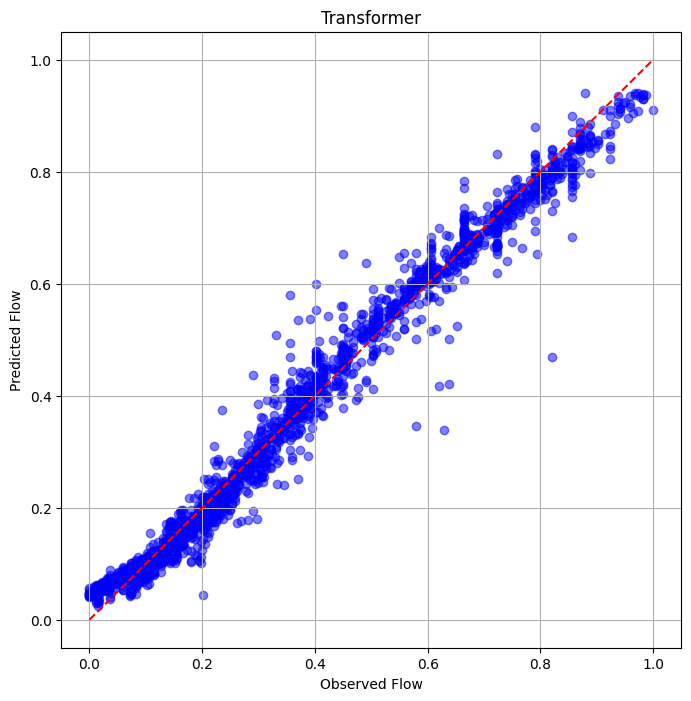

In [42]:
import matplotlib.pyplot as plt

# Assuming you have arrays y_pred and y_observed
# y_pred and y_observed should have the same length
y_pred = best_model.predict(X).flatten()
y_observed = y
plt.figure(figsize=(8, 8))
plt.scatter(y_observed, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_observed), max(y_observed)], [min(y_observed), max(y_observed)], color='red', linestyle='--')
plt.title('Transformer')
plt.xlabel('Observed Flow')
plt.ylabel('Predicted Flow')
plt.grid(True)
plt.show()


In [43]:
# Assuming best_model is your final trained model
best_model.save('/content/drive/MyDrive/research/best_model_transformer_4i.h5')


In [44]:
# Assuming best_model is your trained model
optimizer = best_model.optimizer
learning_rate = float(optimizer.learning_rate.numpy())

# Print the optimizer and learning rate
print("Optimizer:", type(optimizer).__name__)
print("Learning Rate:", learning_rate)

Optimizer: Adam
Learning Rate: 0.004428728949278593


In [45]:
# Assuming best_model is your trained model

# Function to extract dropout rate from a layer
def get_dropout_rate(layer):
    if hasattr(layer, 'rate'):
        return layer.rate
    elif hasattr(layer, 'dropout'):
        return layer.dropout
    else:
        return None

# Iterate through layers of the model and find the dropout rates
dropout_rates = []

for layer in best_model.layers:
    rate = get_dropout_rate(layer)
    if rate is not None:
        dropout_rates.append((layer.name, rate))

# Print the dropout rates
print("Dropout Rates:")
for layer_name, rate in dropout_rates:
    print(f"{layer_name}: {rate}")

Dropout Rates:
dropout_501: 0.41334630069916445
dropout_502: 0.41334630069916445
dropout_503: 0.108512469730255
dropout_504: 0.108512469730255
dropout_505: 0.21951765260893089
dropout_506: 0.46032819940741143


In [46]:
best_hyperparameters_dict = best_model_hyperparameters.values
worst_hyperparameters_dict = worst_model_hyperparameters.values

print("Best Hyperparameters:", best_hyperparameters_dict)
print("Worst Hyperparameters:", worst_hyperparameters_dict)

Best Hyperparameters: {'num_transformer_blocks': 2, 'head_size': 136, 'num_heads': 2, 'ff_dim': 22, 'dropout_0': 0.41334630069916445, 'dropout_1': 0.108512469730255, 'num_mlp_layers': 2, 'mlp_units_0': 192, 'mlp_dropout_0': 0.21951765260893089, 'optimizer': 'adam', 'learning_rate': 0.004428728929594218, 'dropout_2': 0.11247888387013175, 'dropout_3': 0.5860293116751504, 'dropout_4': 0.3236663952432144, 'dropout_5': 0.45359332283565845, 'dropout_6': 0.5329891003542448, 'dropout_7': 0.47321661969824136, 'mlp_units_1': 160, 'mlp_dropout_1': 0.46032819940741143}
Worst Hyperparameters: {'num_transformer_blocks': 2, 'head_size': 200, 'num_heads': 8, 'ff_dim': 34, 'dropout_0': 0.46970305890855435, 'dropout_1': 0.418586128333276, 'num_mlp_layers': 1, 'mlp_units_0': 192, 'mlp_dropout_0': 0.5193021079668062, 'optimizer': 'adam', 'learning_rate': 0.0030012700968539583, 'dropout_2': 0.2088005461869151, 'dropout_3': 0.37762255112412857, 'dropout_4': 0.32603033406473825, 'dropout_5': 0.32122508972464

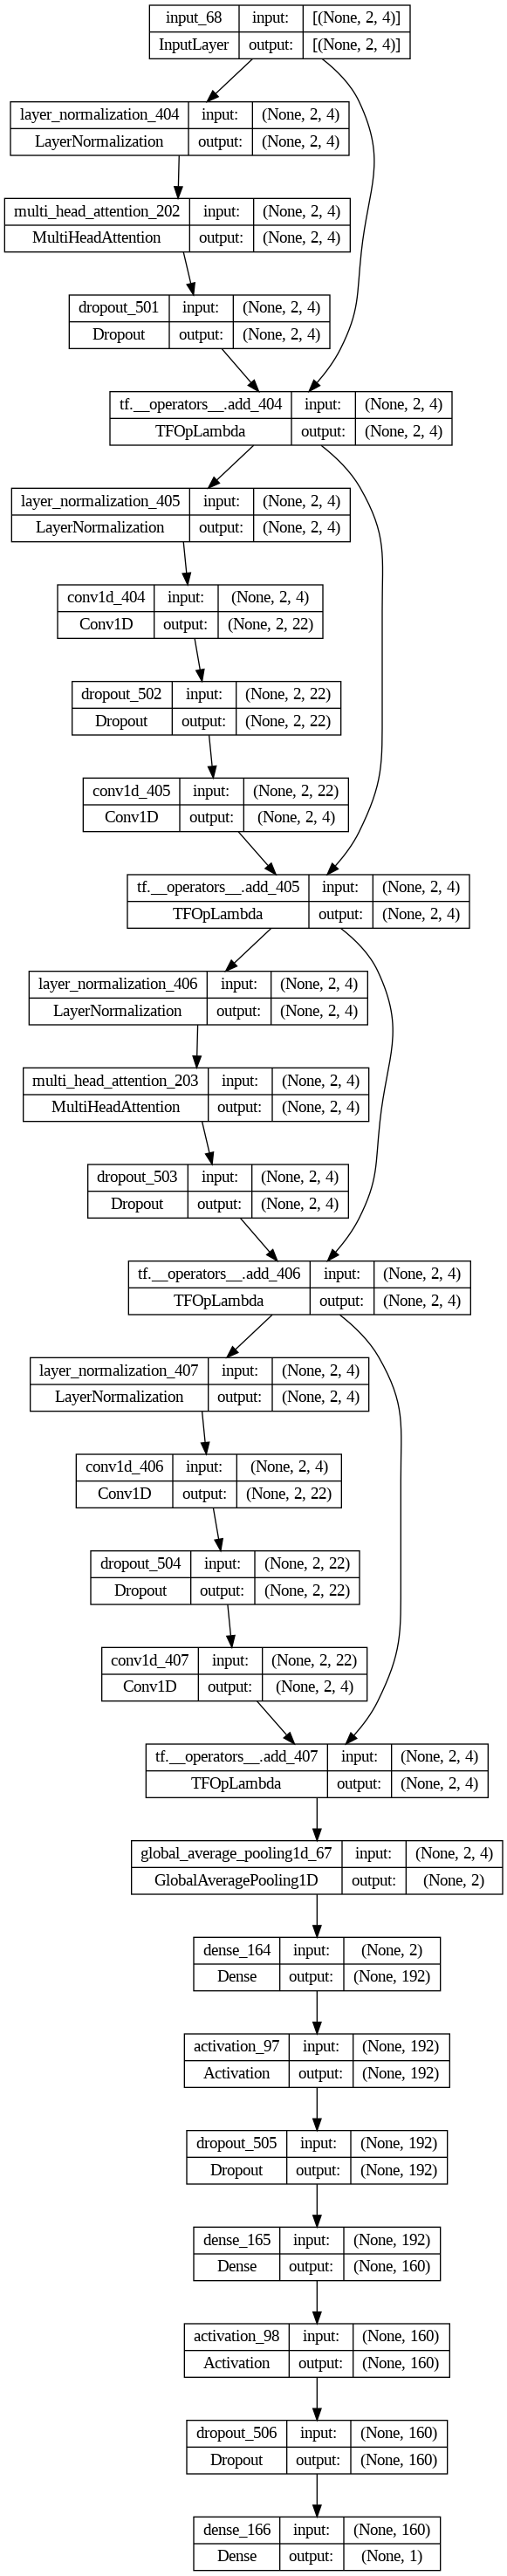

In [47]:
from keras.utils import plot_model
# Visualize the model architecture and save the diagram to a file
plot_model(best_model, to_file='tf_model.png', show_shapes=True, show_layer_names=True)

# for 3 input value

In [17]:

# Print or use the nested_scores as needed
print("Nested Cross-Validation Scores:")
for i, scores in enumerate(nested_scores):
    print(f"\nFold {i + 1} - MSE: {scores['Best Model']['MSE']}, R^2: {scores['Best Model']['R^2']}, RMSE: {scores['Best Model']['RMSE']}, MAE: {scores['Best Model']['MAE']}, kge: {scores['Best Model']['kge']}, nse: {scores['Best Model']['nse']}")


# Calculate overall statistics
all_mse = [scores['Best Model']['MSE'] for scores in nested_scores]
all_mae = [scores['Best Model']['MAE'] for scores in nested_scores]
all_rsme = [scores['Best Model']['RMSE'] for scores in nested_scores]
all_r2 = [scores['Best Model']['R^2'] for scores in nested_scores]
all_kge = [scores['Best Model']['kge'] for scores in nested_scores]
all_nse = [scores['Best Model']['nse'] for scores in nested_scores]
all_time = [scores['Best Model']['testing time'] for scores in nested_scores]
mean_mse = np.mean(all_mse)
mean_mae = np.mean(all_mae)
mean_rsme = np.mean(all_rsme)
mean_r2 = np.mean(all_r2)
mean_kge = np.mean(all_kge)
mean_nse = np.mean(all_nse)
mean_time = np.mean(all_time)

print(f"Mean MSE: {mean_mse:.3f}")
print(f"Mean MAE: {mean_mae:.3f}")
print(f"Mean RMSE: {mean_rsme:.3f}")
print(f"Mean R^2: {mean_r2:.3f}")
print(f"Mean kge: {mean_kge:.3f}")
print(f"Mean nse: {mean_nse:.3f}")
print(f"Mean time: {mean_time:.3f}")

Nested Cross-Validation Scores:

Fold 1 - MSE: 0.0009324111639749317, R^2: 0.98424634569051, RMSE: 0.030535408364306047, MAE: 0.017891396381726682, kge: [0.96635259], nse: [0.98424635]

Fold 2 - MSE: 0.0006914542073322205, R^2: 0.9880701384453086, RMSE: 0.026295516867561673, MAE: 0.016088452696153003, kge: [0.97814826], nse: [0.98807014]

Fold 3 - MSE: 0.0007088648220131099, R^2: 0.9875763724908387, RMSE: 0.02662451543245642, MAE: 0.016223556554088036, kge: [0.97503757], nse: [0.98757637]

Fold 4 - MSE: 0.0005912979656107567, R^2: 0.9904131939711405, RMSE: 0.024316619123775342, MAE: 0.01264904321644379, kge: [0.98267819], nse: [0.99041319]

Fold 5 - MSE: 0.00045641741472485936, R^2: 0.99222113936083, RMSE: 0.021363927886155657, MAE: 0.011570940086688039, kge: [0.98311319], nse: [0.99222114]
Mean MSE: 0.001
Mean MAE: 0.015
Mean RMSE: 0.026
Mean R^2: 0.989
Mean kge: 0.977
Mean nse: 0.989
Mean time: 1.015


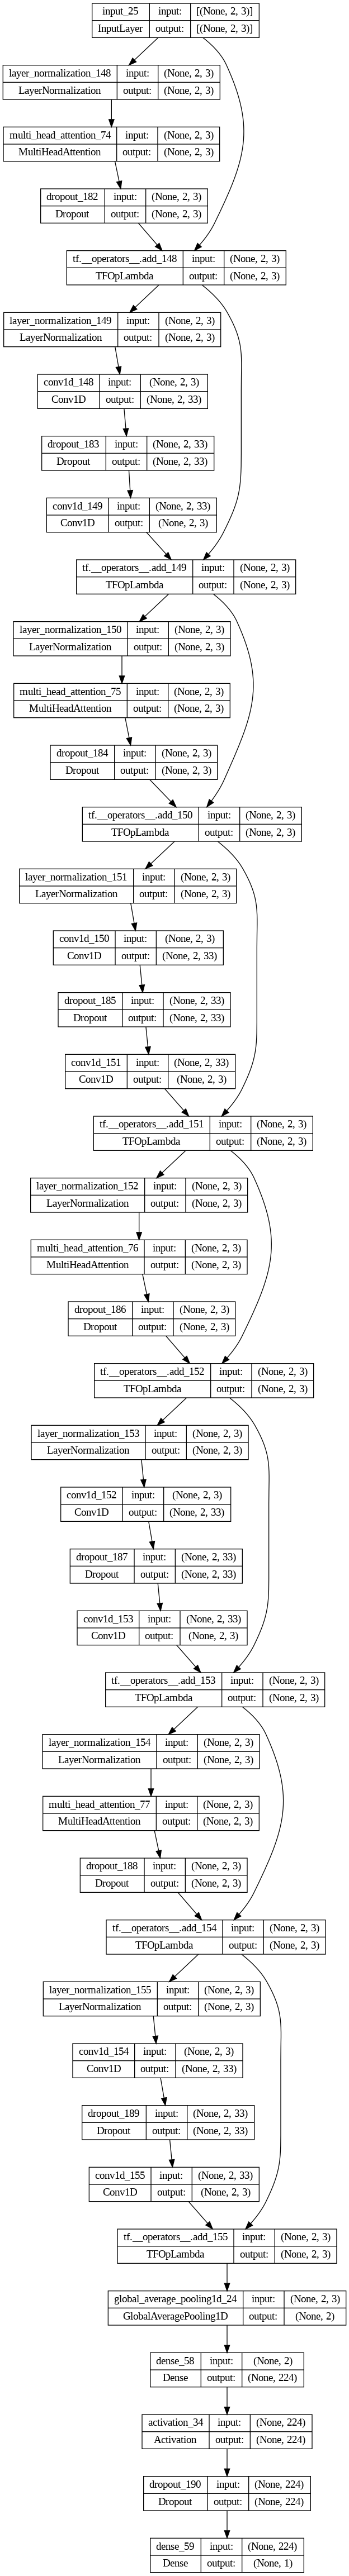

In [18]:
from keras.utils import plot_model
# Visualize the model architecture and save the diagram to a file
plot_model(best_model, to_file='tf_model.png', show_shapes=True, show_layer_names=True)

In [19]:
# Assuming best_model is your trained model

# Function to extract dropout rate from a layer
def get_dropout_rate(layer):
    if hasattr(layer, 'rate'):
        return layer.rate
    elif hasattr(layer, 'dropout'):
        return layer.dropout
    else:
        return None

# Iterate through layers of the model and find the dropout rates
dropout_rates = []

for layer in best_model.layers:
    rate = get_dropout_rate(layer)
    if rate is not None:
        dropout_rates.append((layer.name, rate))

# Print the dropout rates
print("Dropout Rates:")
for layer_name, rate in dropout_rates:
    print(f"{layer_name}: {rate}")

Dropout Rates:
dropout_182: 0.3197935459621283
dropout_183: 0.3197935459621283
dropout_184: 0.33207564889919794
dropout_185: 0.33207564889919794
dropout_186: 0.38543986942069774
dropout_187: 0.38543986942069774
dropout_188: 0.42032602643210293
dropout_189: 0.42032602643210293
dropout_190: 0.17436089466272983


In [20]:
# Assuming best_model is your trained model
optimizer = best_model.optimizer
learning_rate = float(optimizer.learning_rate.numpy())

# Print the optimizer and learning rate
print("Optimizer:", type(optimizer).__name__)
print("Learning Rate:", learning_rate)

Optimizer: Adam
Learning Rate: 0.004830113612115383


In [21]:
# Assuming best_model is your final trained model
best_model.save('/content/drive/MyDrive/research/best_model_transformer.h5')


126/126 [==============================] - 1s 8ms/step


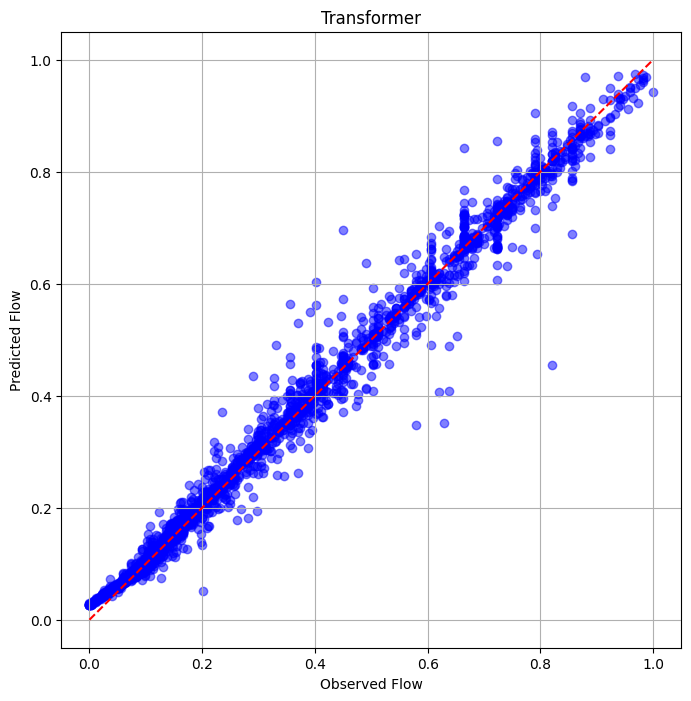

In [22]:
import matplotlib.pyplot as plt

# Assuming you have arrays y_pred and y_observed
# y_pred and y_observed should have the same length
y_pred = best_model.predict(X).flatten()
y_observed = y
plt.figure(figsize=(8, 8))
plt.scatter(y_observed, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_observed), max(y_observed)], [min(y_observed), max(y_observed)], color='red', linestyle='--')
plt.title('Transformer')
plt.xlabel('Observed Flow')
plt.ylabel('Predicted Flow')
plt.grid(True)
plt.show()
